# Работа с SyntaxNet
Для запуска сетки с теггером используем следующий bash-скприпт:

~~~bash
PARSER_EVAL=bazel-bin/syntaxnet/parser_eval
CONTEXT=syntaxnet/models/parsey_universal/context.pbtxt
if [[ "$1" == "--conll" ]]; then
  INPUT_FORMAT=stdin-conll
  shift
else
  INPUT_FORMAT=stdin
fi
MODEL_DIR=$1

$PARSER_EVAL \
  --input=$INPUT_FORMAT \
  --output=stdout-conll \
  --hidden_layer_sizes=64 \
  --arg_prefix=brain_morpher \
  --graph_builder=structured \
  --task_context=$CONTEXT \
  --resource_dir=$MODEL_DIR \
  --model_path=$MODEL_DIR/morpher-params \
  --slim_model \
  --batch_size=1024 \
  --alsologtostderr \
  | \
  $PARSER_EVAL \
  --input=stdin-conll \
  --output=stdout-conll \
  --hidden_layer_sizes=64 \
  --arg_prefix=brain_tagger \
  --graph_builder=structured \
  --task_context=$CONTEXT \
  --resource_dir=$MODEL_DIR \
  --model_path=$MODEL_DIR/tagger-params \
  --slim_model \
  --batch_size=1024 \
  --alsologtostderr \
  | \
  $PARSER_EVAL \
  --input=stdin-conll \
  --output=stdout-conll \
  --hidden_layer_sizes=512,512 \
  --arg_prefix=brain_parser \
  --graph_builder=structured \
  --task_context=$CONTEXT \
  --resource_dir=$MODEL_DIR \
  --model_path=$MODEL_DIR/parser-params \
  --slim_model \
  --batch_size=1024 \
  --alsologtostderr
~~~

Для запуска сетки без теггера используем следующий bash-скприпт:

~~~bash
PARSER_EVAL=bazel-bin/syntaxnet/parser_eval
CONTEXT=syntaxnet/models/parsey_universal/context.pbtxt
if [[ "$1" == "--conll" ]]; then
  INPUT_FORMAT=stdin-conll
  shift
else
  INPUT_FORMAT=stdin
fi
MODEL_DIR=$1

$PARSER_EVAL \
  --input=$INPUT_FORMAT \
  --output=stdout-conll \
  --hidden_layer_sizes=64 \
  --arg_prefix=brain_morpher \
  --graph_builder=structured \
  --task_context=$CONTEXT \
  --resource_dir=$MODEL_DIR \
  --model_path=$MODEL_DIR/morpher-params \
  --slim_model \
  --batch_size=1024 \
  --alsologtostderr \
  | \
  $PARSER_EVAL \
  --input=stdin-conll \
  --output=stdout-conll \
  --hidden_layer_sizes=512,512 \
  --arg_prefix=brain_parser \
  --graph_builder=structured \
  --task_context=$CONTEXT \
  --resource_dir=$MODEL_DIR \
  --model_path=$MODEL_DIR/parser-params \
  --slim_model \
  --batch_size=1024 \
  --alsologtostderr
~~~

In [1]:
import sys
import nltk
import math
import time
import collections
import itertools
from itertools import cycle, islice
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parse_connl(connlu_file):
    tag_count = collections.defaultdict(int)
    attr_count = collections.defaultdict(int)
    dep_count = collections.defaultdict(int)
    word_count = collections.defaultdict(int)
    token_count = 0
    for line in connlu_file:
        first_symb = line.split('\t')[0] # that's index of word
        if first_symb.isdigit(): # if it is digit - that's index of word in sentence
            word = line.split('\t')[1] # taking word
            word_count[word] += 1 
            token_count += 1 # counter of all tokens
            pos = line.split('\t')[3] # taking tag
            tag_count[pos] += 1 #tag count
            
            attributes = line.split('\t')[5] #parsing attributes
            for attr in ['Abbr', 'Foreign', 'Poss', 'Reflex']:
                index = attributes.find(attr)
                if index != -1:
                    index += len(attr)
                    index += 1 # symbol =
                    nstring = ''
                    if attr != 'Foreign':
                        nstring = attributes[index:index+len('Yes')]
                    else:
                        nstring = attributes[index:index+len('Foreign')] # apparently for Foreign attr Yes==Foreign
                    if nstring == 'Yes' or nstring == 'Foreign':
                        attr_count[attr] += 1
            for attr in ['Animacy', 'Aspect', 'Case', 'Definite', 'Degree',\
                         'Evident', 'Gender', 'Mood', 'NumType', 'Number',\
                         'Person', 'Polarity', 'Polite', 'PronType', 'Tense',\
                         'VerbForm', 'Voice']:
                index = attributes.find(attr)
                if index != -1:
                    index += len(attr)
                    cut_string = attributes[index:]
                    index_start = cut_string.find('=')
                    index_start += 1 # =
                    index_end = cut_string.find('|')
                    if index_end == -1:
                        index_end = cut_string.find('\t')
                    if index_end != -1:
                        value = cut_string[index_start:index_end]
                        attr_name = attr + ':' + value
                        attr_count[attr_name] += 1
            
            dep = line.split('\t')[7] #parsing dependencies
            dep_count[dep] += 1 
    
    return token_count, word_count, tag_count, attr_count, dep_count

In [3]:
def pos(tag_count):
    doc_df = pd.DataFrame([(lambda tag, count: { 'PoS' : tag, 'Count' : count})(tag, count) \
                           for tag, count in tag_count.items() ])
    doc_df['CountNorm'] = doc_df.Count.apply(lambda x : float(x)/sum(doc_df.Count))
    doc_df = doc_df[['PoS', 'Count','CountNorm']]
    return doc_df

def attr_st(attr_count):
    doc_df = pd.DataFrame([(lambda attr, count: { 'Attribute' : attr, 'Count' : count})(attr, count) \
                           for attr, count in attr_count.items() ])
    doc_df['CountNorm'] = doc_df.Count.apply(lambda x : float(x)/sum(doc_df.Count))
    doc_df = doc_df[['Attribute', 'Count','CountNorm']]
    return doc_df

def dep_st(dep_count):
    doc_df = pd.DataFrame([(lambda dep, count: { 'Dependency' : dep, 'Count' : count})(dep, count) \
                           for dep, count in dep_count.items() ])
    doc_df['CountNorm'] = doc_df.Count.apply(lambda x : float(x)/sum(doc_df.Count))
    doc_df = doc_df[['Dependency', 'Count','CountNorm']]
    return doc_df

def plot_st(data, column, title):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k', 'black', 'orange', 'purple', 'gray']), None, len(data)))
    data.plot(x=column, y='CountNorm', kind='bar', figsize=(5, 5), grid=False, title=title, legend=False, color=my_colors)
    plt.show()

# Tamil

Тами́льский язы́к (самоназвание: தமிழ்) — самый южный из дравидийских языков. На нём говорит население южной Индии, начиная от северной пограничной черты (где оканчивается телугу), проходящей на несколько миль севернее Ченнаи, и кончая мысом Коморин на юге — то есть почти вся южная оконечность Индии, за исключением неширокой полосы по западному её берегу, занятой родственным дравидийским языком малаялам. Кроме того, на тамильском языке говорит население северной половины Цейлона.

Тамильский язык располагает богатой 2300-летней литературной историей и считается классическим языком.


### Точности
- POS - 79.29%  
- UAS - 64.45%  
- LAS - 55.35%  

In [4]:
connl_tatest = open("UD_Tamil/ta-ud-test.conllu", "r", encoding="UTF-8")
connl_tatrain = open("UD_Tamil/ta-ud-train.conllu", "r", encoding="UTF-8")
connl_file_tatest = connl_tatest.readlines()
connl_file_tatrain = connl_tatrain.readlines()
connl_tatest.close()
connl_tatrain.close()

tatest_token_count, tatest_word_count, tatest_tag_count, tatest_attr_count, tatest_dep_count = parse_connl(connl_file_tatest)
tatrain_token_count, tatrain_word_count, tatrain_tag_count, tatrain_attr_count, tatrain_dep_count = parse_connl(connl_file_tatrain)

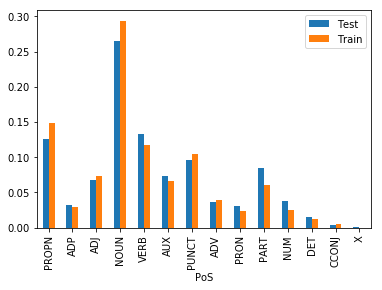

In [5]:
tatest_pos = pos(tatest_tag_count)
tatrain_pos = pos(tatrain_tag_count)
df_test = tatest_pos[['PoS','CountNorm']].rename(columns={'CountNorm':'Test'})
df_train = tatrain_pos[['PoS','CountNorm']].rename(columns={'CountNorm':'Train'})
df = df_test.merge(df_train,how='outer').fillna(0).set_index('PoS')
df.plot(kind='bar')

## Универсальные PoS теги

In [6]:
connl_ta = open("ta.conll", "r")
connl_file_ta = connl_ta.readlines()
connl_ta.close()
ta_token_count, ta_word_count, ta_tag_count,ta_attr_count, ta_dep_count = parse_connl(connl_file_ta)
print ("All tokens count:", ta_token_count)
print ("Unique tokens count:", len(ta_word_count.keys()))
ta_pos = pos(ta_tag_count)
ta_pos

All tokens count: 1989
Unique tokens count: 983


,PoS,Count,CountNorm
0,NOUN,568,0.285571
1,ADP,49,0.024635
2,PROPN,226,0.113625
3,VERB,232,0.116642
4,AUX,155,0.077929
5,PUNCT,189,0.095023
6,ADJ,166,0.083459
7,ADV,69,0.034691
8,PART,169,0.084967
9,PRON,61,0.030669


In [7]:
# cmap = cm.get_cmap('jet')
# labels = []
# ax = ta_pos.plot(labels=None, y='CountNorm', kind='pie', legend=True, figsize=(10,10), colormap=cmap, fontsize=10)
# patches, labels = ax.get_legend_handles_labels()
# for a,b in zip(ta_pos.PoS.values, ta_pos.CountNorm.values):
#     string = str(a) + ':' + "{:.4f}".format(b)
#     labels.append(string)
# ax.legend(labels=labels, fontsize=15, bbox_to_anchor=(1.4, 0.9))
# plt.show()

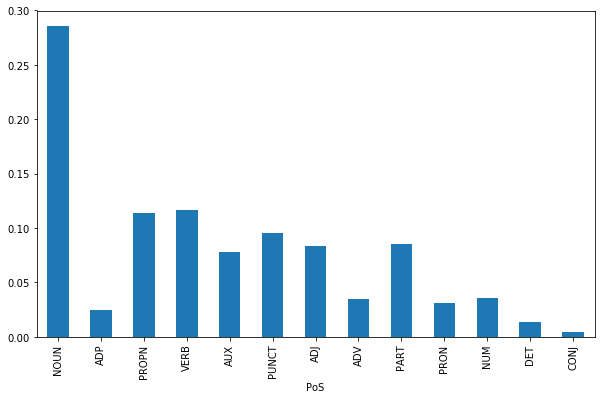

In [8]:
ta_pos.plot(x='PoS', y='CountNorm', kind='bar',  figsize=(10,6), legend=False)
plt.show()

## Универсальные грамматические атрибуты

  Attribute  Count  CountNorm
0    Reflex      1        1.0


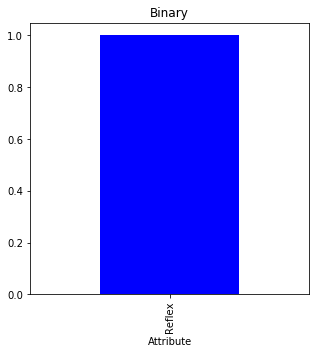

В исходном файле действительно втретился только один бинарный атрибут и только один раз


In [9]:
binary_stat = {}
for attr in ['Abbr', 'Foreign', 'Poss', 'Reflex']:
    for k,v in ta_attr_count.items():
        if k.find(attr) != -1:
            binary_stat[attr] = v 
df = attr_st(binary_stat)
print(df)
plot_st(df, 'Attribute', 'Binary')
print("В исходном файле действительно втретился только один бинарный атрибут и только один раз")

-----------------------------------------===== Case =====-------------------------------------------------
  Attribute  Count  CountNorm
0       Nom    578   0.698912
1       Dat     57   0.068924
2       Loc     86   0.103990
3       Acc     68   0.082225
4       Gen     27   0.032648
5       Ins      7   0.008464
6       Com      4   0.004837


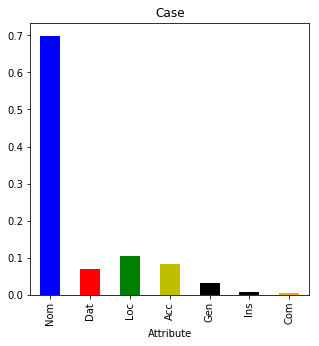

-----------------------------------------===== Gender =====-------------------------------------------------
  Attribute  Count  CountNorm
0      Neut    839   0.797529
1       Com    213   0.202471


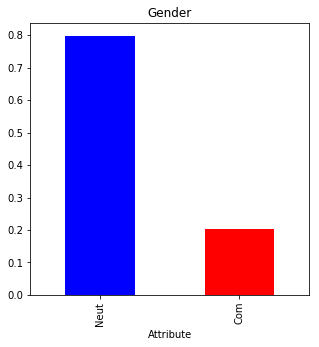

-----------------------------------------===== Mood =====-------------------------------------------------
  Attribute  Count  CountNorm
0       Ind    167    0.97093
1       Cnd      5    0.02907


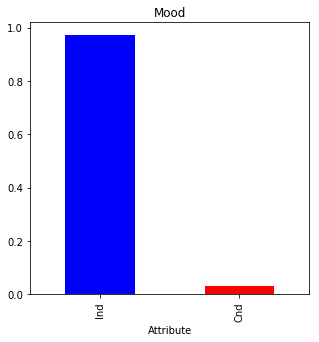

-----------------------------------------===== NumType =====-------------------------------------------------
  Attribute  Count  CountNorm
0      Card     34   0.790698
1       Ord      9   0.209302


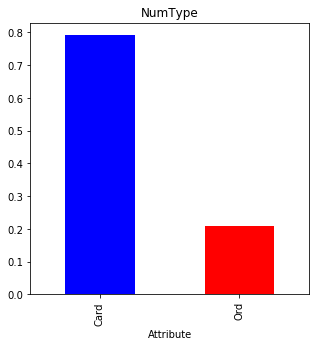

-----------------------------------------===== Number =====-------------------------------------------------
  Attribute  Count  CountNorm
0      Sing    870   0.825427
1      Plur    184   0.174573


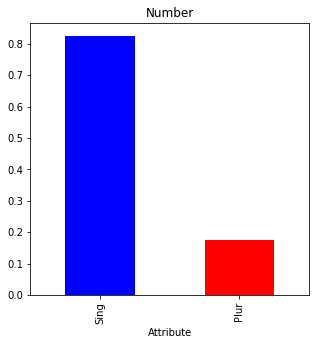

-----------------------------------------===== Person =====-------------------------------------------------
  Attribute  Count  CountNorm
0         3   1045   0.991461
1         1      9   0.008539


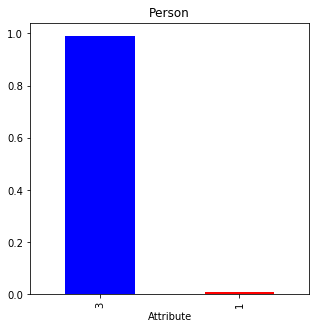

-----------------------------------------===== PronType =====-------------------------------------------------
  Attribute  Count  CountNorm
0       Prs     46   0.938776
1       Int      2   0.040816
2       Ind      1   0.020408


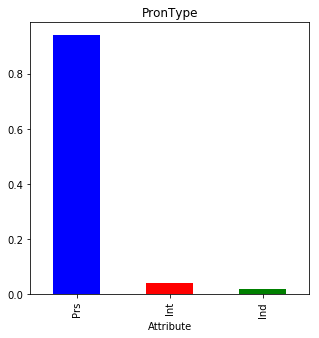

-----------------------------------------===== Tense =====-------------------------------------------------
  Attribute  Count  CountNorm
0      Pres     28   0.120172
1       Fut     92   0.394850
2      Past    113   0.484979


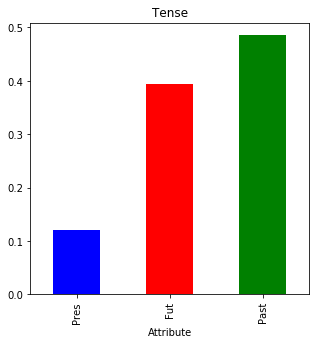

-----------------------------------------===== VerbForm =====-------------------------------------------------
  Attribute  Count  CountNorm
0      Part    196   0.358974
1       Fin    172   0.315018
2       Inf    119   0.217949
3       Ger     59   0.108059


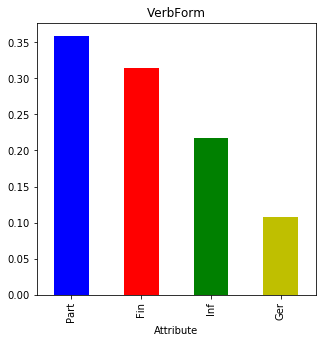

-----------------------------------------===== Voice =====-------------------------------------------------
  Attribute  Count  CountNorm
0       Act    382   0.931707
1      Pass     28   0.068293


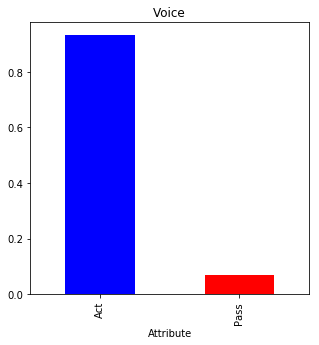

In [10]:
attr_only_spec = {}
for attr in ['Animacy', 'Aspect', 'Case', 'Definite', 'Degree',\
                         'Evident', 'Gender', 'Mood', 'NumType', 'Number',\
                         'Person', 'Polarity', 'Polite', 'PronType', 'Tense',\
                         'VerbForm', 'Voice']:
    spec_dict = {}
    for k,v in ta_attr_count.items():
        if k.find(attr) != -1:
            new_key = k[k.find(':')+1:] # taking second part of name, attribute specific
            spec_dict[new_key] = v
    if len(spec_dict) > 1: # only attributes with more than 1 value
        attr_only_spec[attr] = spec_dict
for k,v in attr_only_spec.items():  
    df = attr_st(attr_only_spec[k])
    print("-----------------------------------------=====", k, "=====-------------------------------------------------")
    print(df)
    plot_st(df, 'Attribute', k)

In [11]:
attr_no_spec = collections.defaultdict(int)
for k,v in ta_attr_count.items():
    if k.find(':') != -1:
        new_key = k[0:k.find(':')]
        attr_no_spec[new_key] += v
    else:
        attr_no_spec[k] += v
ta_attr_no_spec = attr_st(attr_no_spec)
ta_attr_no_spec

,Attribute,Count,CountNorm
0,Case,827,0.146268
1,Gender,1052,0.186063
2,Number,1054,0.186417
3,Person,1054,0.186417
4,Animacy,79,0.013972
5,VerbForm,546,0.096569
6,Voice,410,0.072515
7,Mood,172,0.030421
8,Tense,233,0.041210
9,Polite,134,0.023700


In [12]:
# ax = ta_attr_no_spec.plot(labels=None, y='CountNorm', kind='pie', legend=False, figsize=(10,10), colormap=cmap, fontsize=10)
# labels = []
# for a,b in zip(ta_attr_no_spec.Attribute.values, ta_attr_no_spec.CountNorm.values):
#     string = str(a) + ':' + "{:.4f}".format(b)
#     labels.append(string)
# ax.legend(labels=labels, fontsize=15, bbox_to_anchor=(1.3, 0.9))
# plt.show()


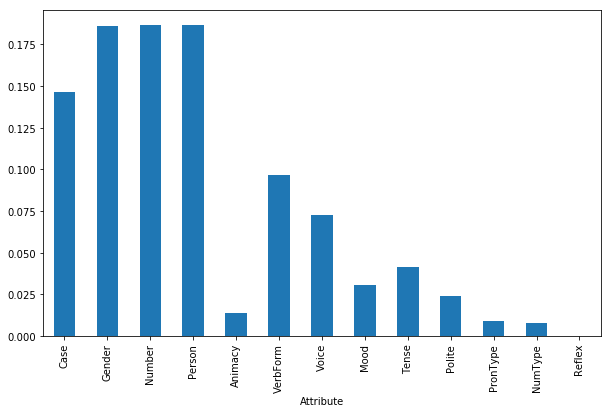

In [13]:
ta_attr_no_spec.plot(x='Attribute', y='CountNorm', kind='bar',  figsize=(10,6), legend=False)
plt.show()

## Универсальные зависимости

In [14]:
ta_dep = dep_st(ta_dep_count)
ta_dep


,Dependency,Count,CountNorm
0,nmod,561,0.282051
1,case,56,0.028155
2,nsubj,130,0.065359
3,dobj,135,0.067873
4,ROOT,120,0.060332
5,aux,154,0.077426
6,punct,186,0.093514
7,amod,146,0.073404
8,advmod,77,0.038713
9,advcl,60,0.030166


In [15]:
# ax = ta_dep.plot(labels=None, y='CountNorm', kind='pie', legend=False, figsize=(10,10), colormap=cmap, fontsize=10)
# labels = []
# for a,b in zip(ta_dep.Dependency.values, ta_dep.CountNorm.values):
#     string = str(a) + ':' + "{:.4f}".format(b)
#     labels.append(string)
# ax.legend(labels=labels, fontsize=14, bbox_to_anchor=(1.3, 0.9))
# plt.show()

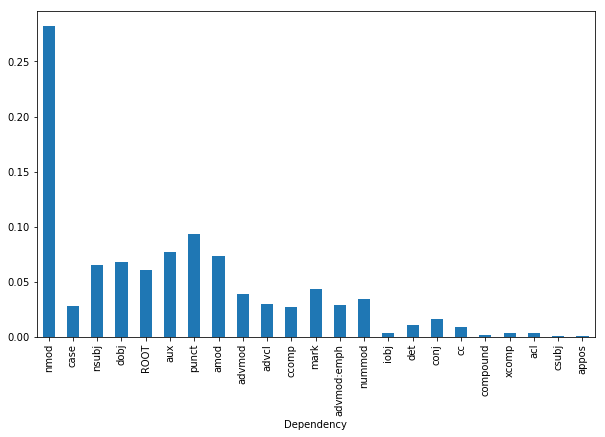

In [16]:
ta_dep.plot(x='Dependency', y='CountNorm', kind='bar',  figsize=(10,6), legend=False)
plt.show()

# Estonian

Эсто́нский язы́к (самоназвание — eesti keel) — язык эстонцев, относящийся к прибалтийско-финской ветви финно-угорской семьи языков. Официальный язык Эстонии и Европейского союза. Письменность на основе латинского алфавита.

Эстонский язык является родным языком для примерно 1 миллиона человек. Из них большинство (около 900 000 человек) — жители Эстонии.

Эстонский язык примечателен тремя степенями длины звуков (как гласных, так и согласных): короткие, длинные и сверхдлинные. Различные длины звуков дают слову разное значение.

### Точности
- POS - 95.92%   
- UAS - 83.10%  
- LAS - 78.83%   

In [17]:
connl_estest = open("UD_Estonian/et-ud-test.conllu", "r", encoding="UTF-8")
connl_estrain = open("UD_Estonian/et-ud-train.conllu", "r", encoding="UTF-8")
connl_file_estest = connl_estest.readlines()
connl_file_estrain = connl_estrain.readlines()
connl_estest.close()
connl_estrain.close()

estest_token_count, estest_word_count, estest_tag_count, estest_attr_count, estest_dep_count = parse_connl(connl_file_estest)
estrain_token_count, estrain_word_count, estrain_tag_count, estrain_attr_count, estrain_dep_count = parse_connl(connl_file_estrain)

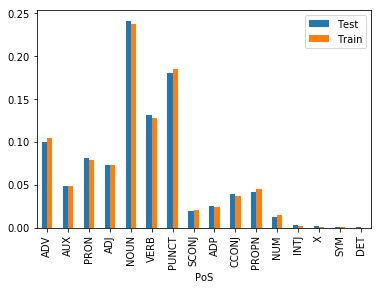

In [18]:
estest_pos = pos(estest_tag_count)
estrain_pos = pos(estrain_tag_count)
df_test = estest_pos[['PoS','CountNorm']].rename(columns={'CountNorm':'Test'})
df_train = estrain_pos[['PoS','CountNorm']].rename(columns={'CountNorm':'Train'})
df = df_test.merge(df_train,how='outer').fillna(0).set_index('PoS')
df.plot(kind='bar')

## Универсальные PoS теги

In [19]:
connl_es = open("et.conll", "r")
connl_file_es = connl_es.readlines()
connl_es.close()
es_token_count, es_word_count, es_tag_count, es_attr_count, es_dep_count = parse_connl(connl_file_es)
print ("All tokens count:", es_token_count)
print ("Unique tokens count:", len(es_word_count.keys()))
es_pos = pos(es_tag_count)
es_pos

All tokens count: 10618
Unique tokens count: 4928


,PoS,Count,CountNorm
0,ADV,1080,0.101714
1,AUX,272,0.025617
2,PRON,811,0.076380
3,ADJ,841,0.079205
4,NOUN,2581,0.243078
5,VERB,1630,0.153513
6,PUNCT,1917,0.180542
7,SCONJ,219,0.020625
8,ADP,257,0.024204
9,CONJ,420,0.039555


In [20]:
# labels = []
# ax = es_pos.plot(labels=None, y='CountNorm', kind='pie', legend=True, figsize=(10,10), colormap=cmap, fontsize=10)
# patches, labels = ax.get_legend_handles_labels()
# for a,b in zip(es_pos.PoS.values, es_pos.CountNorm.values):
#     string = str(a) + ':' + "{:.4f}".format(b)
#     labels.append(string)
# ax.legend(labels=labels, fontsize=15, bbox_to_anchor=(1.4, 0.9))
# plt.show()

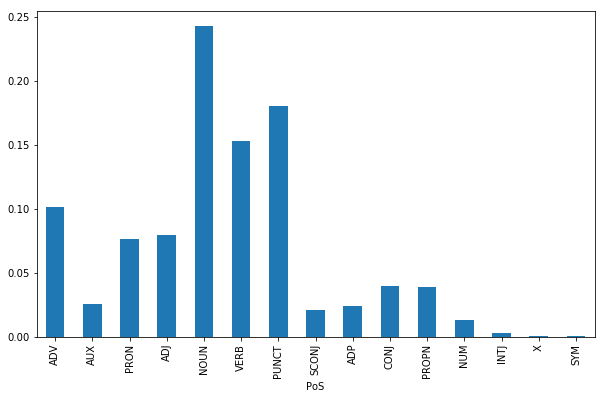

In [21]:
es_pos.plot(x='PoS', y='CountNorm', kind='bar',  figsize=(10,6), legend=False)
plt.show()

## Универсальные грамматические атрибуты

  Attribute  Count  CountNorm
0      Abbr     45   0.454545
1      Poss     35   0.353535
2    Reflex     19   0.191919


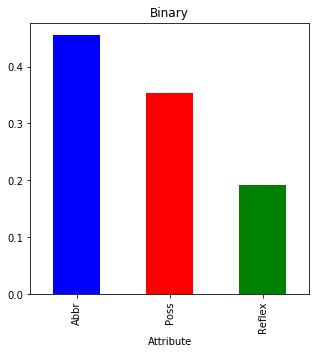

In [22]:
binary_stat = {}
for attr in ['Abbr', 'Foreign', 'Poss', 'Reflex']:
    for k,v in es_attr_count.items():
        if k.find(attr) != -1:
            binary_stat[attr] = v 
df = attr_st(binary_stat)
print(df)
plot_st(df, 'Attribute', 'Binary')

-----------------------------------------===== Case =====-------------------------------------------------
   Attribute  Count  CountNorm
0        Nom   1626   0.345884
1        Ine    231   0.049138
2        Gen   1165   0.247820
3        Par    597   0.126994
4        Ill    113   0.024037
5        Com    131   0.027866
6        All    178   0.037864
7        Tra     88   0.018719
8        Ade    234   0.049777
9        Add     80   0.017018
10       Abe     12   0.002553
11       Ela    179   0.038077
12       Abl     23   0.004893
13       Ess     27   0.005743
14       Ter     17   0.003616


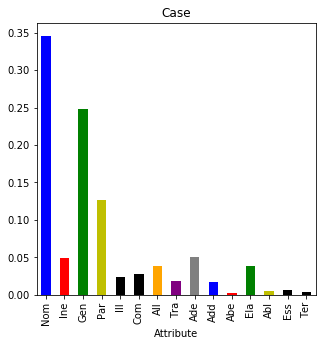

-----------------------------------------===== Degree =====-------------------------------------------------
  Attribute  Count  CountNorm
0       Pos    594   0.904110
1       Cmp     59   0.089802
2       Sup      4   0.006088


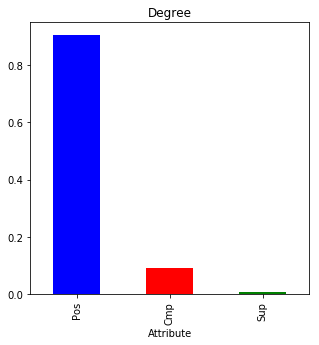

-----------------------------------------===== Mood =====-------------------------------------------------
  Attribute  Count  CountNorm
0       Ind   1413   0.941372
1       Cnd     50   0.033311
2       Imp     37   0.024650
3       Qot      1   0.000666


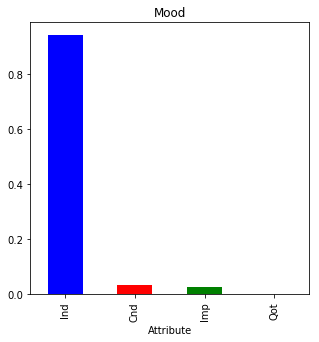

-----------------------------------------===== NumType =====-------------------------------------------------
  Attribute  Count  CountNorm
0      Card    138   0.704082
1       Ord     58   0.295918


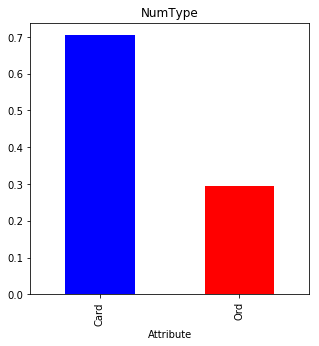

-----------------------------------------===== Number =====-------------------------------------------------
  Attribute  Count  CountNorm
0      Sing   4821   0.830348
1      Plur    985   0.169652


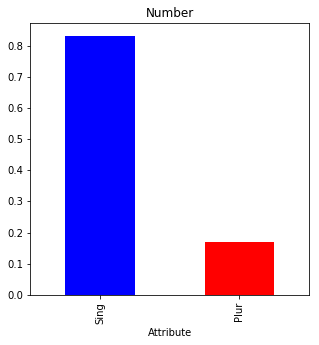

-----------------------------------------===== Person =====-------------------------------------------------
  Attribute  Count  CountNorm
0         3   1149   0.736067
1         1    316   0.202434
2         2     96   0.061499


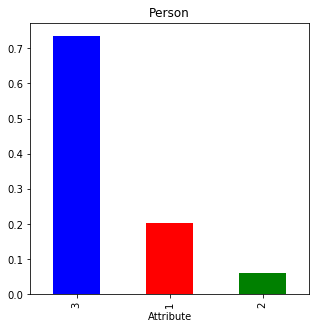

-----------------------------------------===== PronType =====-------------------------------------------------
  Attribute  Count  CountNorm
0       Prs    425   0.498826
1       Dem    235   0.275822
2   Int,Rel    106   0.124413
3       Tot     27   0.031690
4       Ind     52   0.061033
5       Rel      7   0.008216


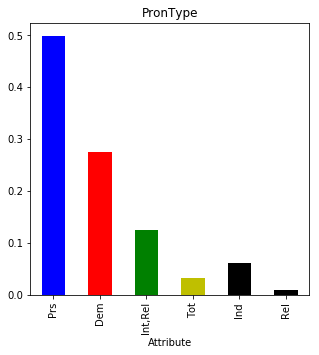

-----------------------------------------===== Tense =====-------------------------------------------------
  Attribute  Count  CountNorm
0      Past    962   0.582324
1      Pres    686   0.415254
2       Imp      4   0.002421


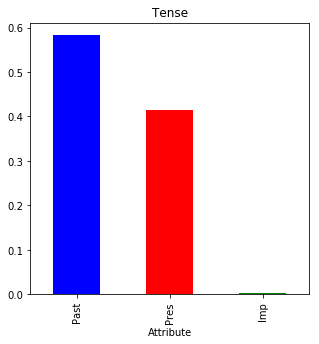

-----------------------------------------===== VerbForm =====-------------------------------------------------
  Attribute  Count  CountNorm
0       Fin   1501   0.726525
1      Part    258   0.124879
2       Inf    177   0.085673
3       Ger     46   0.022265
4       Sup     84   0.040658


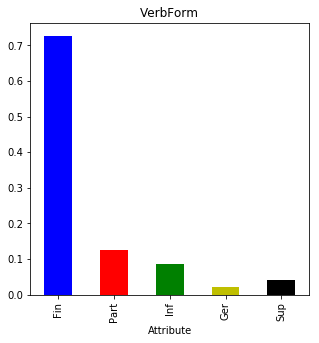

-----------------------------------------===== Voice =====-------------------------------------------------
  Attribute  Count  CountNorm
0       Act   1630    0.93894
1      Pass    106    0.06106


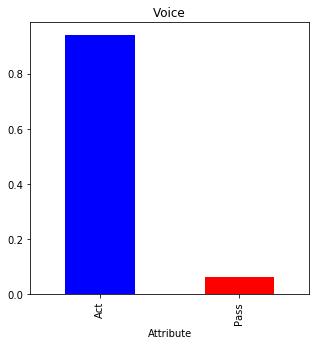

In [23]:
attr_only_spec = {}
for attr in ['Animacy', 'Aspect', 'Case', 'Definite', 'Degree',\
                         'Evident', 'Gender', 'Mood', 'NumType', 'Number',\
                         'Person', 'Polarity', 'Polite', 'PronType', 'Tense',\
                         'VerbForm', 'Voice']:
    spec_dict = {}
    for k,v in es_attr_count.items():
        if k.find(attr) != -1:
            new_key = k[k.find(':')+1:] # taking second part of name, attribute specific
            spec_dict[new_key] = v
    if len(spec_dict) > 1: # only attributes with more than 1 value
        attr_only_spec[attr] = spec_dict
for k,v in attr_only_spec.items():  
    df = attr_st(attr_only_spec[k])
    print("-----------------------------------------=====", k, "=====-------------------------------------------------")
    print(df)
    plot_st(df, 'Attribute', k)

In [24]:
attr_no_spec = collections.defaultdict(int)
for k,v in es_attr_count.items():
    if k.find(':') != -1:
        new_key = k[0:k.find(':')]
        attr_no_spec[new_key] += v
    else:
        attr_no_spec[k] += v
es_attr_no_spec = attr_st(attr_no_spec)
es_attr_no_spec

,Attribute,Count,CountNorm
0,Mood,1501,0.072070
1,Number,5806,0.278773
2,Person,1561,0.074951
3,Tense,1652,0.079320
4,VerbForm,2066,0.099198
5,Voice,1736,0.083353
6,Case,4701,0.225717
7,PronType,852,0.040908
8,Degree,657,0.031546
9,NumType,196,0.009411


In [25]:
# ax = es_attr_no_spec.plot(labels=None, y='CountNorm', kind='pie', legend=False, figsize=(10,10), colormap=cmap, fontsize=10)
# labels = []
# for a,b in zip(es_attr_no_spec.Attribute.values, es_attr_no_spec.CountNorm.values):
#     string = str(a) + ':' + "{:.4f}".format(b)
#     labels.append(string)
# ax.legend(labels=labels, fontsize=15, bbox_to_anchor=(1.3, 0.9))
# plt.show()


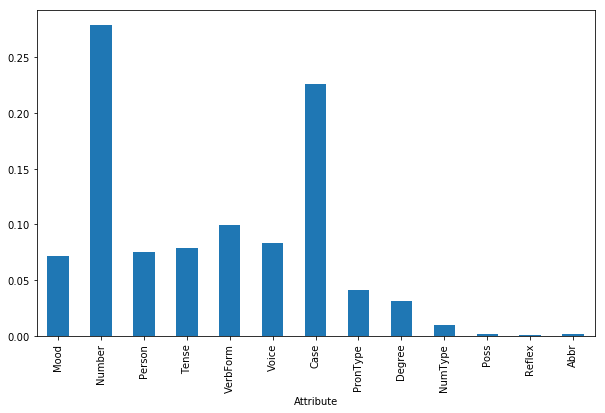

In [26]:
es_attr_no_spec.plot(x='Attribute', y='CountNorm', kind='bar',  figsize=(10,6), legend=False)
plt.show()

## Универсальные зависимости

In [27]:
es_dep = dep_st(es_dep_count)
es_dep


,Dependency,Count,CountNorm
0,advmod,848,0.079864
1,aux,161,0.015163
2,nsubj,840,0.079111
3,amod,525,0.049444
4,nmod,1753,0.165097
5,ROOT,861,0.081089
6,det,141,0.013279
7,dobj,497,0.046807
8,punct,1921,0.180919
9,nsubj:cop,128,0.012055


In [28]:
# ax = es_dep.plot(labels=None, y='CountNorm', kind='pie', legend=False, figsize=(10,10), colormap=cmap, fontsize=10)
# labels = []
# for a,b in zip(es_dep.Dependency.values, es_dep.CountNorm.values):
#     string = str(a) + ':' + "{:.4f}".format(b)
#     labels.append(string)
# ax.legend(labels=labels, fontsize=14, bbox_to_anchor=(1.3, 0.9))
# plt.show()

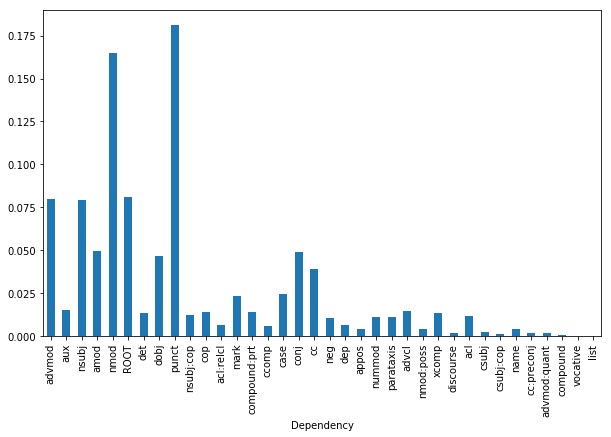

In [29]:
es_dep.plot(x='Dependency', y='CountNorm', kind='bar',  figsize=(10,6), legend=False)
plt.show()

# Проективные синтаксические деревья

In [56]:
def get_dependencies(filename):
    with open(filename, encoding="UTF-8") as f:
        text = f.readlines()
    dependencies = list()
    current = dict()
    for line in text:
        line = line.split('\t')
        if line[0].isdigit():
            if int(line[0]) == 1:
                if current != dict():
                    dependencies.append(current)
                current = dict()
            if int(line[6]) in current:
                current[int(line[6])].append(int(line[0]))
            else:
                current[int(line[6])] = [int(line[0])]
    return dependencies

def check(dependencies, id_word, lb, ub):
    if id_word < lb or id_word > ub:
        return False
    if id_word in dependencies.keys():
        for new_word in dependencies[id_word]:
            if new_word < id_word:
                return check(dependencies, new_word, lb, min(ub, id_word))
            else:
                return check(dependencies, new_word, max(lb, id_word), ub)
    return True

def get_not_projective_sentence(filename):
    dependencies = get_dependencies(filename)
    result = list()
    for i in range(len(dependencies)):
        if not check(dependencies[i], 0, -1, float("inf")):
            result.append(i)
    return result, len(dependencies)

def get_sentences(filename):
    with open(filename, encoding="UTF-8") as f:
        text = f.readlines()
    result = list()
    ids = list()
    for line in text:
        if line.startswith("# sent_id = "):
            ids.append(line.replace("# sent_id = ","")[:-1])
        if line.startswith("# text ="):
            result.append(line.replace("# text = ", ""))
    return result, ids


## Tamil

In [57]:
print("Train:")
ta_train_notproj, ltrn = get_not_projective_sentence("UD_Tamil/ta-ud-train.conllu")
print ("Number of projective:", ltrn - len(ta_train_notproj))
print ("Number of NOT projective:", len(ta_train_notproj))

print("Test:")
ta_test_notproj, ltst = get_not_projective_sentence("UD_Tamil/ta-ud-test.conllu")
print ("Number of projective:", ltst - len(ta_test_notproj))
print ("Number of NOT projective:", len(ta_test_notproj))


Train:
Number of projective: 399
Number of NOT projective: 0
Test:
Number of projective: 119
Number of NOT projective: 0


Все предложения в корпусе Тамильского языка обладают свойством проективности. Отдельно выводить их нет необходимости.

## Estonian

In [58]:
print("Train:")
es_train_notproj, ltrn = get_not_projective_sentence("UD_Estonian/et-ud-train.conllu")
print ("Projective:", ltrn - len(es_train_notproj), "NOT projective:", len(es_train_notproj))

print("Test:")
es_test_notproj, ltst = get_not_projective_sentence("UD_Estonian/et-ud-test.conllu")
print ("Number of projective:", ltst - len(es_test_notproj))
print ("Number of NOT projective:", len(es_test_notproj))

Train:
Number of projective: 6918
Number of NOT projective: 40
Test:
Number of projective: 854
Number of NOT projective: 6


In [59]:
print("Not tagged:")
es_notproj, l = get_not_projective_sentence("et.conll")
print ("Number of projective:", l - len(es_notproj))
print ("Number of NOT projective:", len(es_notproj))

print("Tagged:")
es_tagged_notproj, ltg = get_not_projective_sentence("et_tagged.conll")
print ("Number of projective:", ltg - len(es_tagged_notproj))
print ("Number of NOT projective:", len(es_tagged_notproj))


Not tagged:
Number of projective: 860
Number of NOT projective: 0
Tagged:
Number of projective: 860
Number of NOT projective: 0


Похоже на то, что SyntaxNet строит неправильные синтаксические деревья для тех предложений, в которых отсутствует свойство проективности.

In [61]:
print("Not projective sentences:")
sentences, ids = get_sentences("UD_Estonian/et-ud-test.conllu")
for i in es_test_notproj:
    print (ids[i], " : ", sentences[i])
    
sentences, ids = get_sentences("UD_Estonian/et-ud-train.conllu")
for i in es_train_notproj:
    print (ids[i], " : ", sentences[i])

Not projective sentences:
ilu_valton_300  :  Selles Tsee isepäisus avalduski, et ta valis laudanurka uue aseme, mida oli juba varem, õieti selgelt aimamata milleks, välja vaadanud ning kujutlenud.

ilu_vilep_600  :  All kõnniteel seisis kursusekaaslane ülikoolipäevilt -- noor, nagu ta siis oli.

aja_epl20070812_10  :   President Viktor Juštšenko on tuntud kui läänemeelne poliitik, peaminister Viktor Janukovitš aga kui venemeelne, kirjutab BBC.

aja_sloleht20071217_210  :  Algajatel tasub jooksu aega iga päev paari minuti võrra pikendada.

aja_sloleht20071217_320  :  Eesti kaheksa parema meestennisisti osalusel peetud Gild Masters-turniiri võitis teist aastat järjest Jürgen Zopp, alistades finaalis 6:4, 6:1 Vladimir Ivanovi.

aja_sloleht20071217_670  :  Reedel üritab Tallinnas olümpiapiletit kindlustada

ilu_indrikson_14  :   Aga seljas oli tal "Baltika" poeülikond, seegi umbes viis aastat vana.

ilu_indrikson_162  :   Kõik olid suvilas: naine, tütred ja Indriksoni ema.

ilu_indrikson_2

In [64]:
print("Projective sentences:")
sentences, ids = get_sentences("UD_Estonian/et-ud-train.conllu")
for i in range(ltrn):
    print (ids[i], " : ", sentences[i])


Projective sentences:
ilu_indrikson_1  :   Sõna "Lufthansa" ei kõlanud Indriksoni kodus ammu erakordselt.

ilu_indrikson_2  :   Esiteks poleks "Lufthansata" Saksamaale lennata saanudki, teiseks kohustas firma tase.

ilu_indrikson_3  :   Ärimaailm oli kohati ju tõesti upsakas ja kõle, aga Indrikson oli õigel ajal alustanud mees.

ilu_indrikson_4  :   Tema oli sisse elanud ja teadis juba hästi, millise lennukiga lennata ning millist lipsu kanda.

ilu_indrikson_5  :   Praegu oli naljakas meenutadagi, et pärast keskkooli oli ta tahtnud väga draamanäitlejaks saada.

ilu_indrikson_6  :   Millest nad ära elavad, mõtles ta mõnikord.

ilu_indrikson_7  :   Millest nad üüri maksavad ja millest lapsi koolitavad?

ilu_indrikson_8  :   Imede ime!

ilu_indrikson_11  :   Timmani-poiss maitses sääraseid roogi esimest korda elus.

ilu_indrikson_12  :   Eks need imelikud suutäied olid ja ega eesti mees neist söönuks saanud.

ilu_indrikson_13  :   Timman oli hea artist ja käitus uues miljöös väärika rahug